# Data Adequacy Assessment for Clustering Analysis

This notebook conducts a comprehensive data adequacy assessment for the building energy calibration clustering dataset. The assessment includes:

1. **Variability Assessment**: Coefficient of variation analysis and distribution visualizations
2. **Feature Selection**: Variance-based selection, correlation analysis, and PCA dimensionality reduction
3. **Sample Size Analysis**: Evaluation of sample size requirements for k-prototypes clustering
4. **Hopkins Statistic Calculation**: Assessment of cluster tendency in the data
5. **Missing Data Investigation**: Analysis of missingness patterns and their impact

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Libraries loaded successfully.")

Libraries loaded successfully.


## 2. Load and Inspect Dataset

In [2]:
# Load the complete dataset
path = "../data/"
df = pd.read_csv(path + "df_complete.csv")

print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"\nDataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nColumn names and data types:")
print("-" * 40)
for col in df.columns:
    print(f"  {col}: {df[col].dtype}")

# Identify numerical and categorical features
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print(f"\n\nNumerical features ({len(numerical_features)}): {numerical_features}")
print(f"\nCategorical features ({len(categorical_features)}): {categorical_features}")

DATASET OVERVIEW

Dataset shape: 5,902 rows × 15 columns

Column names and data types:
----------------------------------------
  building_id: object
  year: int64
  meter: object
  total_meter_reading: float64
  site_id: object
  sqm: float64
  primaryspaceusage: object
  yearbuilt: float64
  region: object
  country: object
  Avg_AirTemp_Annual: float64
  Total_HDD_Annual: float64
  Total_CDD_Annual: float64
  Count_Heating_Days_Annual: int64
  Count_Cooling_Days_Annual: int64


Numerical features (9): ['year', 'total_meter_reading', 'sqm', 'yearbuilt', 'Avg_AirTemp_Annual', 'Total_HDD_Annual', 'Total_CDD_Annual', 'Count_Heating_Days_Annual', 'Count_Cooling_Days_Annual']

Categorical features (6): ['building_id', 'meter', 'site_id', 'primaryspaceusage', 'region', 'country']


In [3]:
# Display basic statistics for numerical features
print("=" * 60)
print("DESCRIPTIVE STATISTICS FOR NUMERICAL FEATURES")
print("=" * 60)
df[numerical_features].describe().round(2)

DESCRIPTIVE STATISTICS FOR NUMERICAL FEATURES


,year,total_meter_reading,sqm,yearbuilt,Avg_AirTemp_Annual,Total_HDD_Annual,Total_CDD_Annual,Count_Heating_Days_Annual,Count_Cooling_Days_Annual
count,5902.00,5.902000e+03,5902.00,2781.00,5902.00,5902.00,5902.00,5902.00,5902.00
mean,2016.51,9.651421e+07,9240.33,1970.14,15.67,1381.26,332.99,161.12,82.62
std,0.50,7.572721e+08,10316.38,29.91,5.71,1042.43,436.85,86.83,70.88
min,2016.00,0.000000e+00,26.30,1900.00,7.53,58.53,0.00,20.00,0.00
25%,2016.00,2.030767e+05,2550.40,1955.00,10.85,310.83,18.61,65.00,14.00
50%,2017.00,7.697052e+05,6100.30,1975.00,14.97,1417.44,160.28,179.00,63.00
75%,2017.00,3.126420e+06,12029.52,1996.00,21.78,2285.00,515.44,235.00,155.00
max,2017.00,2.451400e+10,81290.10,2017.00,25.21,3422.98,1506.85,315.00,201.00


## 3. Variability Assessment

### 3.1 Coefficient of Variation Analysis

The coefficient of variation (CV) measures relative variability and is calculated as:

$$CV = \frac{\sigma}{\mu} \times 100\%$$

**Interpretation guidelines:**
- CV < 10%: Low variability (may indicate insufficient discrimination power for clustering)
- CV 10-100%: Moderate variability (suitable for analysis)
- CV > 100%: High variability (may indicate outliers or need for transformation)

In [4]:
# Calculate Coefficient of Variation for all numerical features
def calculate_cv(series):
    """Calculate coefficient of variation (CV = std/mean * 100)"""
    mean_val = series.mean()
    if mean_val == 0:
        return np.nan
    return (series.std() / abs(mean_val)) * 100

cv_results = {}
for col in numerical_features:
    cv = calculate_cv(df[col].dropna())
    cv_results[col] = cv

# Create CV summary DataFrame
cv_df = pd.DataFrame({
    'Feature': list(cv_results.keys()),
    'Mean': [df[col].mean() for col in cv_results.keys()],
    'Std Dev': [df[col].std() for col in cv_results.keys()],
    'CV (%)': list(cv_results.values())
})

# Classify variability
def classify_variability(cv):
    if pd.isna(cv):
        return 'Undefined'
    elif cv < 10:
        return 'Low (< 10%)'
    elif cv <= 100:
        return 'Moderate (10-100%)'
    else:
        return 'High (> 100%)'

cv_df['Variability Classification'] = cv_df['CV (%)'].apply(classify_variability)
cv_df = cv_df.sort_values('CV (%)', ascending=False)

print("=" * 80)
print("COEFFICIENT OF VARIATION ANALYSIS")
print("=" * 80)
print(cv_df.to_string(index=False))

# Identify features with potential issues
low_var = cv_df[cv_df['Variability Classification'] == 'Low (< 10%)']['Feature'].tolist()
high_var = cv_df[cv_df['Variability Classification'] == 'High (> 100%)']['Feature'].tolist()

print("\n" + "-" * 80)
print("VARIABILITY ASSESSMENT SUMMARY")
print("-" * 80)
if low_var:
    print(f"\nFeatures with INSUFFICIENT variation (CV < 10%): {low_var}")
    print("  → These features may not contribute meaningfully to cluster differentiation.")
else:
    print("\nNo features with insufficient variation identified.")
    
if high_var:
    print(f"\nFeatures with EXCESSIVE variation (CV > 100%): {high_var}")
    print("  → These features may benefit from log transformation or outlier treatment.")
else:
    print("\nNo features with excessive variation identified.")

COEFFICIENT OF VARIATION ANALYSIS
                  Feature         Mean      Std Dev     CV (%) Variability Classification
      total_meter_reading 9.651421e+07 7.572721e+08 784.622360              High (> 100%)
         Total_CDD_Annual 3.329856e+02 4.368493e+02 131.191675              High (> 100%)
                      sqm 9.240331e+03 1.031638e+04 111.645166              High (> 100%)
Count_Cooling_Days_Annual 8.261742e+01 7.088410e+01  85.798011         Moderate (10-100%)
         Total_HDD_Annual 1.381255e+03 1.042429e+03  75.469670         Moderate (10-100%)
Count_Heating_Days_Annual 1.611171e+02 8.682794e+01  53.891207         Moderate (10-100%)
       Avg_AirTemp_Annual 1.567219e+01 5.709045e+00  36.427875         Moderate (10-100%)
                yearbuilt 1.970142e+03 2.991036e+01   1.518182                Low (< 10%)
                     year 2.016507e+03 4.999987e-01   0.024795                Low (< 10%)

-----------------------------------------------------------------

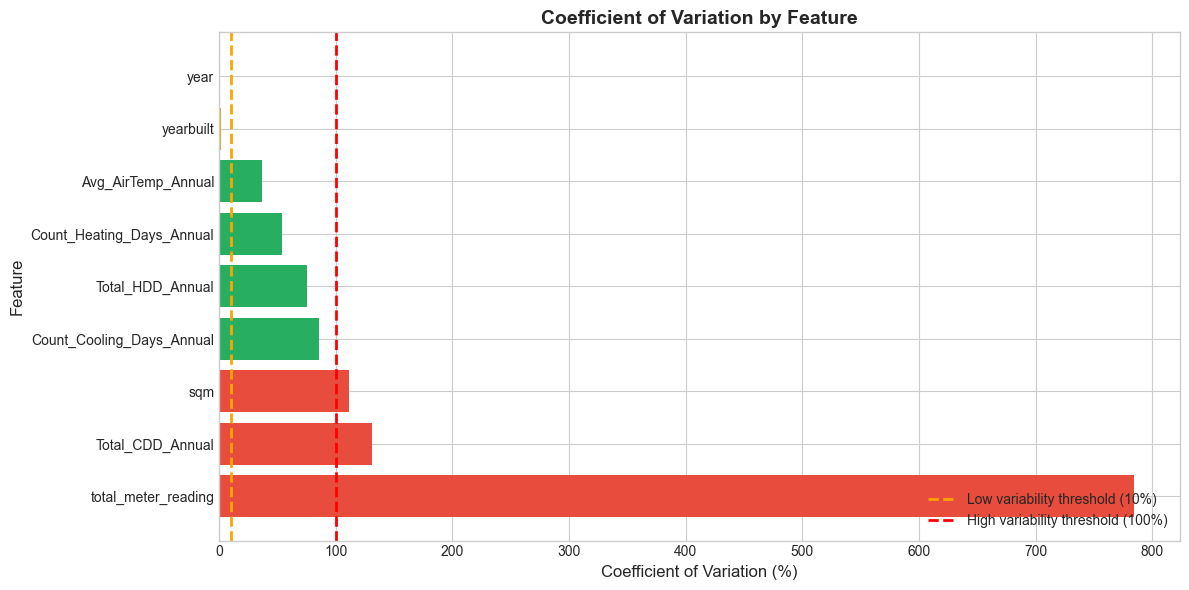

In [5]:
# Visualize CV values
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#e74c3c' if c == 'High (> 100%)' else '#f39c12' if c == 'Low (< 10%)' else '#27ae60' 
          for c in cv_df['Variability Classification']]
bars = ax.barh(cv_df['Feature'], cv_df['CV (%)'], color=colors)
ax.axvline(x=10, color='orange', linestyle='--', linewidth=2, label='Low variability threshold (10%)')
ax.axvline(x=100, color='red', linestyle='--', linewidth=2, label='High variability threshold (100%)')
ax.set_xlabel('Coefficient of Variation (%)', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Coefficient of Variation by Feature', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

### 3.2 Distribution Histograms

The following histograms visualize the distribution shapes of numerical features. Key aspects to identify:
- **Skewness**: Asymmetric distributions that may benefit from log transformation
- **Multimodality**: Multiple peaks suggesting potential natural clusters
- **Outliers**: Extreme values that may distort clustering

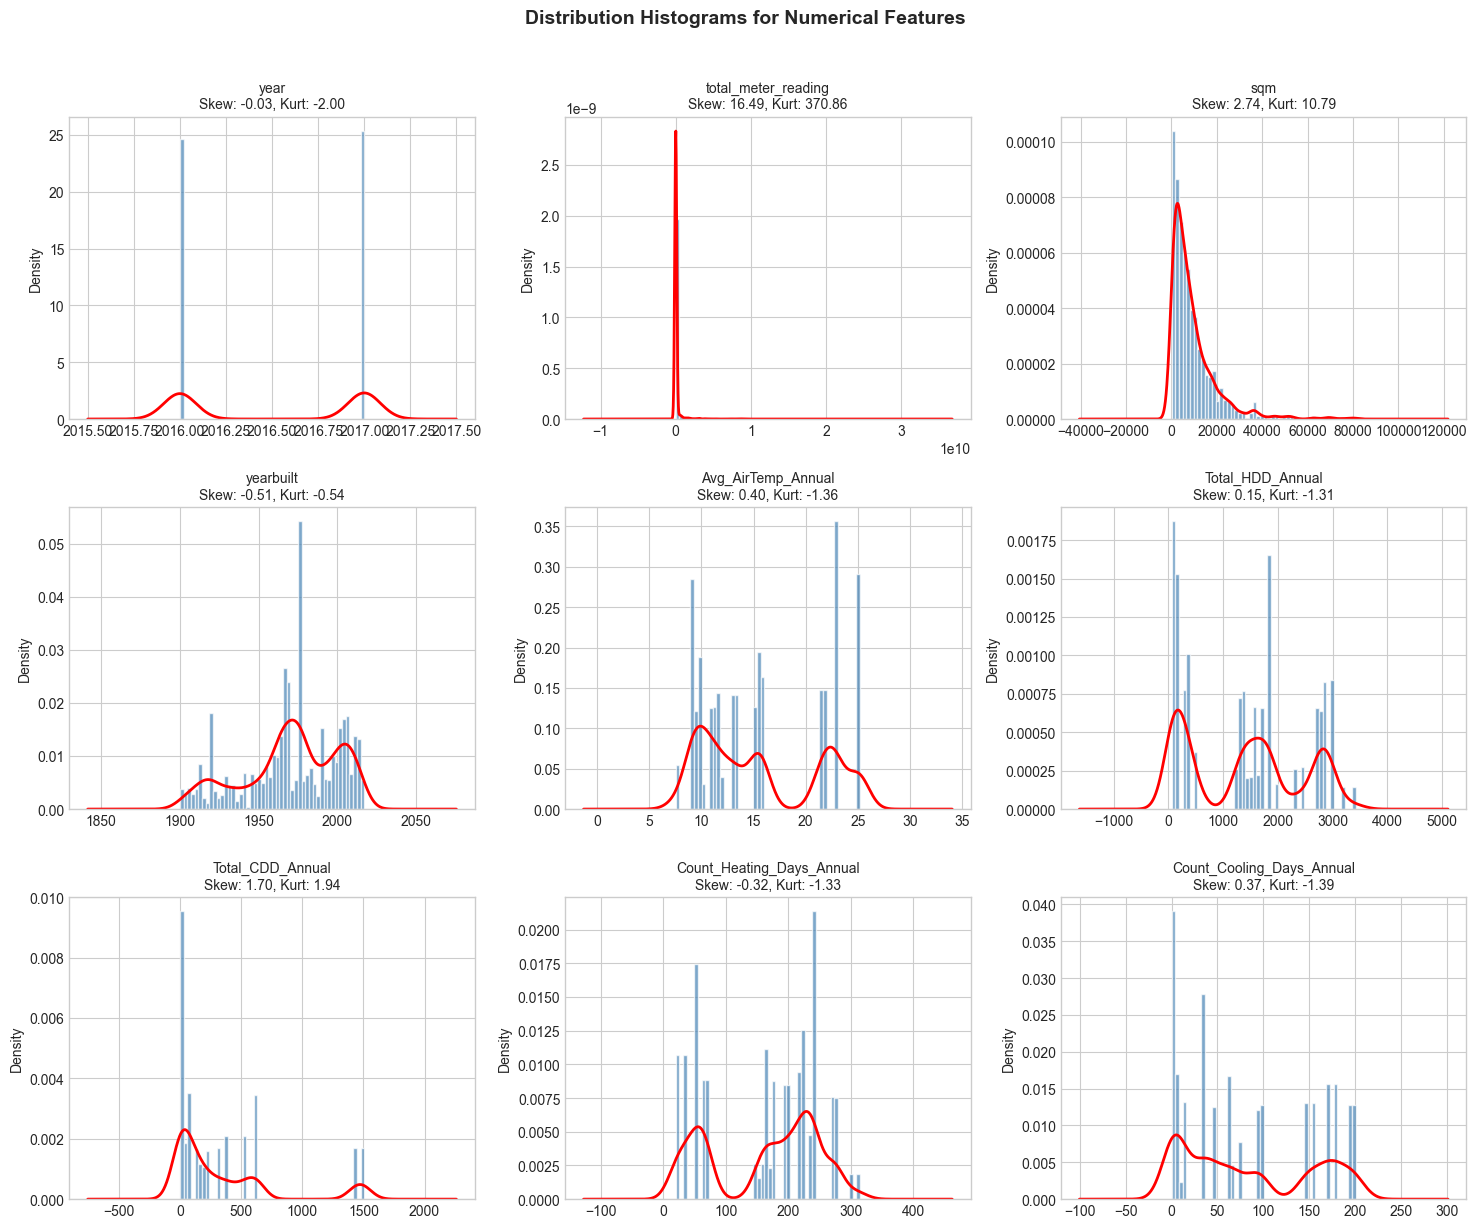


DISTRIBUTION CHARACTERISTICS SUMMARY
Feature                            Skewness     Kurtosis       Transformation
--------------------------------------------------------------------------------
year                                  -0.03        -2.00           Not needed
total_meter_reading                   16.49       370.86          Recommended
sqm                                    2.74        10.79          Recommended
yearbuilt                             -0.51        -0.54           Not needed
Avg_AirTemp_Annual                     0.40        -1.36           Not needed
Total_HDD_Annual                       0.15        -1.31           Not needed
Total_CDD_Annual                       1.70         1.94          Recommended
Count_Heating_Days_Annual             -0.32        -1.33           Not needed
Count_Cooling_Days_Annual              0.37        -1.39           Not needed


In [6]:
# Create histograms for all numerical features
n_features = len(numerical_features)
n_cols = 3
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

distribution_analysis = {}

for idx, col in enumerate(numerical_features):
    ax = axes[idx]
    data = df[col].dropna()
    
    # Calculate skewness and kurtosis
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    
    # Plot histogram with KDE
    ax.hist(data, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='white')
    try:
        data.plot(kind='kde', ax=ax, color='red', linewidth=2)
    except:
        pass
    
    ax.set_title(f'{col}\nSkew: {skewness:.2f}, Kurt: {kurtosis:.2f}', fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('Density')
    
    # Store analysis
    distribution_analysis[col] = {
        'skewness': skewness,
        'kurtosis': kurtosis,
        'needs_transformation': abs(skewness) > 1 or kurtosis > 3
    }

# Hide empty subplots
for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Distribution Histograms for Numerical Features', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary of distribution characteristics
print("\n" + "=" * 80)
print("DISTRIBUTION CHARACTERISTICS SUMMARY")
print("=" * 80)
print(f"{'Feature':<30} {'Skewness':>12} {'Kurtosis':>12} {'Transformation':>20}")
print("-" * 80)
for col, analysis in distribution_analysis.items():
    transform = 'Recommended' if analysis['needs_transformation'] else 'Not needed'
    print(f"{col:<30} {analysis['skewness']:>12.2f} {analysis['kurtosis']:>12.2f} {transform:>20}")

### 3.3 Feature Selection for Clustering

Feature selection in clustering requires different strategies than supervised learning because there's no target variable to guide relevance decisions. The goal is identifying the subset of features that best reveal natural groupings while remaining interpretable for stakeholders.

**Selection Strategies Applied:**
1. **Variance-Based Selection**: Remove features with very low variance (CV < 10%)
2. **Correlation-Based Selection**: Identify and handle highly redundant features (|r| > 0.8)
3. **PCA Dimensionality Reduction**: Reduce dimensionality while preserving variance

In [ ]:
# =============================================================================
# VARIANCE-BASED FEATURE SELECTION
# =============================================================================
from sklearn.feature_selection import VarianceThreshold

print("=" * 80)
print("VARIANCE-BASED FEATURE SELECTION")
print("=" * 80)

# Prepare numerical data for variance analysis
df_numerical = df[numerical_features].copy()

# Standardize first (variance threshold works on raw variance, so we use CV instead)
print("\nFeatures flagged for low variance (CV < 10%):")
print("-" * 60)

low_variance_features = []
adequate_variance_features = []

for col in numerical_features:
    cv_val = cv_results.get(col, np.nan)
    if pd.notna(cv_val) and cv_val < 10:
        low_variance_features.append(col)
        print(f"  ⚠ {col}: CV = {cv_val:.2f}%")
    else:
        adequate_variance_features.append(col)

if not low_variance_features:
    print("  ✓ No features with insufficient variance detected")

print(f"\n\nVariance-Based Selection Summary:")
print(f"  Original numerical features: {len(numerical_features)}")
print(f"  Features with adequate variance: {len(adequate_variance_features)}")
print(f"  Features flagged for removal: {len(low_variance_features)}")

# Store for later use
variance_selected_features = adequate_variance_features.copy()
print(f"\nRetained features: {variance_selected_features}")

### 3.4 Correlation-Based Feature Selection

Highly correlated features (|r| > 0.8) add computational burden without improving clustering quality. However, moderate correlations (0.3-0.7) might indicate related but distinct aspects worth preserving.

In [ ]:
# =============================================================================
# CORRELATION ANALYSIS AND FEATURE SELECTION
# =============================================================================

print("=" * 80)
print("CORRELATION-BASED FEATURE SELECTION")
print("=" * 80)

# Calculate correlation matrix for numerical features with adequate variance
df_corr = df[variance_selected_features].dropna()
corr_matrix = df_corr.corr()

print(f"\nAnalyzing correlations among {len(variance_selected_features)} features...")

# Identify highly correlated pairs (|r| > 0.8)
high_corr_threshold = 0.8
highly_correlated_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > high_corr_threshold:
            highly_correlated_pairs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': corr_val
            })

print("\n" + "-" * 80)
print(f"HIGHLY CORRELATED FEATURE PAIRS (|r| > {high_corr_threshold})")
print("-" * 80)

if highly_correlated_pairs:
    corr_pairs_df = pd.DataFrame(highly_correlated_pairs)
    corr_pairs_df = corr_pairs_df.sort_values('Correlation', key=abs, ascending=False)
    print(corr_pairs_df.to_string(index=False))
    
    # Identify features to potentially remove (keep one from each highly correlated pair)
    features_to_consider_removing = set()
    for pair in highly_correlated_pairs:
        # Keep the feature with higher variance (more informative)
        cv1 = cv_results.get(pair['Feature 1'], 0)
        cv2 = cv_results.get(pair['Feature 2'], 0)
        if cv1 < cv2:
            features_to_consider_removing.add(pair['Feature 1'])
        else:
            features_to_consider_removing.add(pair['Feature 2'])
    
    print(f"\n\nFeatures flagged for potential removal (lower variance in correlated pairs):")
    for f in features_to_consider_removing:
        print(f"  ⚠ {f}")
else:
    print("  ✓ No highly correlated feature pairs detected")
    features_to_consider_removing = set()

# Correlation-selected features
correlation_selected_features = [f for f in variance_selected_features if f not in features_to_consider_removing]
print(f"\n\nCorrelation-Based Selection Summary:")
print(f"  Input features: {len(variance_selected_features)}")
print(f"  Features after correlation filtering: {len(correlation_selected_features)}")
print(f"  Retained features: {correlation_selected_features}")

In [ ]:
# Visualize correlation matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Full correlation heatmap
ax1 = axes[0]
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, vmin=-1, vmax=1, ax=ax1, square=True,
            cbar_kws={'label': 'Correlation Coefficient'})
ax1.set_title('Feature Correlation Matrix\n(Numerical Features)', fontsize=12, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='y', rotation=0)

# Plot 2: Correlation strength distribution
ax2 = axes[1]
# Get upper triangle correlations (excluding diagonal)
upper_tri_indices = np.triu_indices_from(corr_matrix, k=1)
correlations = corr_matrix.values[upper_tri_indices]

ax2.hist(correlations, bins=20, color='steelblue', edgecolor='white', alpha=0.7)
ax2.axvline(x=high_corr_threshold, color='red', linestyle='--', linewidth=2, 
            label=f'High correlation threshold ({high_corr_threshold})')
ax2.axvline(x=-high_corr_threshold, color='red', linestyle='--', linewidth=2)
ax2.axvline(x=0.5, color='orange', linestyle='--', linewidth=1.5, alpha=0.7,
            label='Moderate correlation (0.5)')
ax2.axvline(x=-0.5, color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.set_xlabel('Correlation Coefficient', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of Pairwise Correlations', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right')
ax2.set_xlim(-1, 1)

plt.tight_layout()
plt.show()

# Print correlation summary statistics
print("\n" + "=" * 60)
print("CORRELATION SUMMARY STATISTICS")
print("=" * 60)
print(f"Number of feature pairs analyzed: {len(correlations)}")
print(f"Mean absolute correlation: {np.mean(np.abs(correlations)):.3f}")
print(f"Median absolute correlation: {np.median(np.abs(correlations)):.3f}")
print(f"Max absolute correlation: {np.max(np.abs(correlations)):.3f}")
print(f"Pairs with |r| > 0.8: {np.sum(np.abs(correlations) > 0.8)}")
print(f"Pairs with |r| > 0.5: {np.sum(np.abs(correlations) > 0.5)}")

### 3.5 PCA Dimensionality Reduction Analysis

Principal Component Analysis (PCA) creates new features that capture maximum variance while reducing dimensionality. This is particularly useful when original features measure similar concepts (like multiple climate indicators) and we want to reduce noise while preserving information.

In [ ]:
# =============================================================================
# PCA DIMENSIONALITY REDUCTION ANALYSIS
# =============================================================================
from sklearn.decomposition import PCA

print("=" * 80)
print("PCA DIMENSIONALITY REDUCTION ANALYSIS")
print("=" * 80)

# Prepare data for PCA (use variance-selected features, standardized)
df_pca = df[variance_selected_features].dropna()
scaler_pca = StandardScaler()
X_pca_scaled = scaler_pca.fit_transform(df_pca)

print(f"\nInput data shape: {X_pca_scaled.shape}")
print(f"Features used: {variance_selected_features}")

# Fit PCA with all components first to analyze variance
pca_full = PCA()
pca_full.fit(X_pca_scaled)

# Calculate cumulative explained variance
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("\n" + "-" * 80)
print("EXPLAINED VARIANCE BY COMPONENT")
print("-" * 80)
print(f"{'Component':<12} {'Variance %':>12} {'Cumulative %':>15}")
print("-" * 40)
for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance)):
    print(f"PC{i+1:<10} {var*100:>11.2f}% {cum_var*100:>14.2f}%")

# Determine optimal number of components for different variance thresholds
variance_thresholds = [0.80, 0.90, 0.95]
print("\n" + "-" * 80)
print("COMPONENTS NEEDED FOR VARIANCE THRESHOLDS")
print("-" * 80)
for threshold in variance_thresholds:
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    actual_variance = cumulative_variance[n_components - 1]
    print(f"  {threshold:.0%} variance: {n_components} components (actual: {actual_variance:.1%})")

In [ ]:
# PCA Visualization: Scree Plot and Cumulative Variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Scree Plot
ax1 = axes[0]
components = range(1, len(explained_variance) + 1)
ax1.bar(components, explained_variance * 100, color='steelblue', alpha=0.7, label='Individual')
ax1.plot(components, explained_variance * 100, 'ro-', markersize=8, label='Individual (line)')
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Explained Variance (%)', fontsize=12)
ax1.set_title('PCA Scree Plot', fontsize=12, fontweight='bold')
ax1.set_xticks(components)
ax1.legend()

# Plot 2: Cumulative Variance
ax2 = axes[1]
ax2.plot(components, cumulative_variance * 100, 'b-o', markersize=8, linewidth=2)
ax2.axhline(y=80, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='80% threshold')
ax2.axhline(y=90, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='90% threshold')
ax2.axhline(y=95, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='95% threshold')
ax2.fill_between(components, cumulative_variance * 100, alpha=0.3)
ax2.set_xlabel('Number of Components', fontsize=12)
ax2.set_ylabel('Cumulative Explained Variance (%)', fontsize=12)
ax2.set_title('Cumulative Explained Variance', fontsize=12, fontweight='bold')
ax2.set_xticks(components)
ax2.set_ylim(0, 105)
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
# PCA Component Loadings Analysis
print("=" * 80)
print("PCA COMPONENT LOADINGS")
print("=" * 80)
print("\nFeature contributions to principal components (loadings):")

# Create loadings dataframe
loadings = pd.DataFrame(
    pca_full.components_.T,
    columns=[f'PC{i+1}' for i in range(len(variance_selected_features))],
    index=variance_selected_features
)

# Show loadings for first 3-4 components
n_display_components = min(4, len(variance_selected_features))
print("\n" + "-" * 80)
print(f"Loadings for first {n_display_components} principal components:")
print("-" * 80)
print(loadings.iloc[:, :n_display_components].round(3).to_string())

# Visualize loadings heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(loadings.iloc[:, :n_display_components], annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, ax=ax, cbar_kws={'label': 'Loading'})
ax.set_title(f'PCA Component Loadings (First {n_display_components} Components)', 
             fontsize=12, fontweight='bold')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Original Feature')
plt.tight_layout()
plt.show()

# Identify dominant features for each component
print("\n" + "-" * 80)
print("DOMINANT FEATURES PER COMPONENT (|loading| > 0.4)")
print("-" * 80)
for i in range(n_display_components):
    pc_name = f'PC{i+1}'
    dominant = loadings[pc_name][abs(loadings[pc_name]) > 0.4].sort_values(key=abs, ascending=False)
    if len(dominant) > 0:
        print(f"\n{pc_name} (explains {explained_variance[i]*100:.1f}% variance):")
        for feat, load in dominant.items():
            direction = "+" if load > 0 else "-"
            print(f"  {direction} {feat}: {load:.3f}")

### 3.6 Feature Selection Summary and Recommendations

This section consolidates findings from variance analysis, correlation analysis, and PCA to provide actionable feature selection recommendations.

In [ ]:
# =============================================================================
# FEATURE SELECTION SUMMARY
# =============================================================================

print("=" * 80)
print("FEATURE SELECTION SUMMARY")
print("=" * 80)

# Compile feature selection results
feature_status = {}
for col in numerical_features:
    status = {
        'Original': True,
        'Variance_OK': col not in low_variance_features,
        'Correlation_OK': col not in features_to_consider_removing,
        'CV': cv_results.get(col, np.nan)
    }
    status['Recommended'] = status['Variance_OK'] and status['Correlation_OK']
    feature_status[col] = status

# Create summary DataFrame
summary_df = pd.DataFrame(feature_status).T
summary_df = summary_df.reset_index().rename(columns={'index': 'Feature'})
summary_df['CV'] = summary_df['CV'].round(2)

print("\nNumerical Feature Selection Matrix:")
print("-" * 80)
print(summary_df.to_string(index=False))

# Final recommendations
print("\n" + "=" * 80)
print("FEATURE SELECTION RECOMMENDATIONS")
print("=" * 80)

recommended_features = [f for f, s in feature_status.items() if s['Recommended']]
excluded_features = [f for f, s in feature_status.items() if not s['Recommended']]

print(f"\n✓ RECOMMENDED NUMERICAL FEATURES ({len(recommended_features)}):")
for f in recommended_features:
    cv_val = cv_results.get(f, 0)
    print(f"  • {f} (CV: {cv_val:.1f}%)")

if excluded_features:
    print(f"\n⚠ FEATURES TO CONSIDER EXCLUDING ({len(excluded_features)}):")
    for f in excluded_features:
        reasons = []
        if f in low_variance_features:
            reasons.append("low variance")
        if f in features_to_consider_removing:
            reasons.append("high correlation with retained feature")
        print(f"  • {f} - Reason: {', '.join(reasons)}")

# PCA recommendation
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\n📊 PCA RECOMMENDATION:")
print(f"  If dimensionality reduction needed: Use {n_components_95} components")
print(f"  This captures {cumulative_variance[n_components_95-1]*100:.1f}% of variance")
print(f"  Reduction: {len(variance_selected_features)} → {n_components_95} features")

# Categorical feature notes
print(f"\n📋 CATEGORICAL FEATURES ({len(categorical_features)}):")
print(f"  Features: {categorical_features}")
print("  Note: High-cardinality identifiers (building_id, site_id) should be")
print("        excluded from clustering but retained for result interpretation.")

# Store final selections for use in clustering
final_numerical_features = recommended_features.copy()
final_categorical_features = [f for f in categorical_features if f not in ['building_id', 'site_id']]

print("\n" + "=" * 80)
print("FINAL FEATURE SET FOR CLUSTERING")
print("=" * 80)
print(f"\nNumerical features: {final_numerical_features}")
print(f"Categorical features: {final_categorical_features}")
print(f"Total features: {len(final_numerical_features) + len(final_categorical_features)}")

## 4. Sample Size Analysis

### Sample Size Requirements for Clustering

For k-prototypes and similar clustering algorithms, adequate sample size ensures:
- Stable cluster centroids
- Reliable cluster membership assignments
- Sufficient representation within each cluster

**Guidelines used:**
- Minimum: 50 observations per expected cluster
- Recommended: 100 observations per expected cluster
- Feature-based: At least 10 observations per feature

In [7]:
# Sample Size Analysis
actual_sample_size = len(df)
actual_sample_size_complete = df.dropna().shape[0]

# Define expected clustering parameters
# Based on the building energy domain: primaryspaceusage (7 types), region (multiple), meter type (2-3)
expected_clusters_range = [3, 5, 7, 10, 15]  # Test various k values

# Count features used for clustering (excluding target variable log_eui)
clustering_features_numerical = ['yearbuilt', 'Avg_AirTemp_Annual', 'sqm']  # Based on existing notebook
clustering_features_categorical = ['primaryspaceusage', 'region', 'meter']
total_clustering_features = len(clustering_features_numerical) + len(clustering_features_categorical)

print("=" * 80)
print("SAMPLE SIZE ANALYSIS FOR CLUSTERING")
print("=" * 80)
print(f"\nActual sample size (all rows): {actual_sample_size:,}")
print(f"Complete cases (no missing): {actual_sample_size_complete:,}")
print(f"\nFeatures planned for clustering: {total_clustering_features}")
print(f"  - Numerical: {clustering_features_numerical}")
print(f"  - Categorical: {clustering_features_categorical}")

print("\n" + "-" * 80)
print("MINIMUM SAMPLE SIZE REQUIREMENTS")
print("-" * 80)
print(f"{'Expected k':<15} {'Min (50/cluster)':<20} {'Rec (100/cluster)':<20} {'Feature-based':<15} {'Adequacy':<20}")
print("-" * 80)

sample_size_results = []
for k in expected_clusters_range:
    min_required = 50 * k
    rec_required = 100 * k
    feature_based = 10 * total_clustering_features
    overall_min = max(min_required, feature_based)
    
    if actual_sample_size >= rec_required:
        adequacy = "✓ Excellent"
    elif actual_sample_size >= min_required:
        adequacy = "○ Adequate"
    else:
        adequacy = "✗ Insufficient"
    
    sample_size_results.append({
        'k': k,
        'min_required': min_required,
        'rec_required': rec_required,
        'feature_based': feature_based,
        'adequacy': adequacy
    })
    
    print(f"{k:<15} {min_required:<20,} {rec_required:<20,} {feature_based:<15} {adequacy:<20}")

print("\n" + "-" * 80)
print("OBSERVATIONS PER CLUSTER PROJECTION")
print("-" * 80)
print(f"{'Expected k':<15} {'Avg obs/cluster':<20} {'Assessment'}")
print("-" * 80)
for k in expected_clusters_range:
    avg_per_cluster = actual_sample_size / k
    if avg_per_cluster >= 100:
        assessment = "Excellent (≥100)"
    elif avg_per_cluster >= 50:
        assessment = "Adequate (50-100)"
    else:
        assessment = "Low (<50)"
    print(f"{k:<15} {avg_per_cluster:<20,.0f} {assessment}")

SAMPLE SIZE ANALYSIS FOR CLUSTERING

Actual sample size (all rows): 5,902
Complete cases (no missing): 2,726

Features planned for clustering: 6
  - Numerical: ['yearbuilt', 'Avg_AirTemp_Annual', 'sqm']
  - Categorical: ['primaryspaceusage', 'region', 'meter']

--------------------------------------------------------------------------------
MINIMUM SAMPLE SIZE REQUIREMENTS
--------------------------------------------------------------------------------
Expected k      Min (50/cluster)     Rec (100/cluster)    Feature-based   Adequacy            
--------------------------------------------------------------------------------
3               150                  300                  60              ✓ Excellent         
5               250                  500                  60              ✓ Excellent         
7               350                  700                  60              ✓ Excellent         
10              500                  1,000                60              ✓ Excell

## 5. Hopkins Statistic Calculation

### Cluster Tendency Assessment

The Hopkins statistic (H) measures whether a dataset contains meaningful clusters or is uniformly distributed. It compares nearest neighbor distances from:
- Random points in the data space → real data points
- Real sample points → other real data points

**Interpretation:**
- H ≈ 0.5: Data is uniformly distributed (no cluster tendency)
- H < 0.5: Data has significant clustering tendency
- H > 0.7: Data is highly clusterable
- H < 0.3: Strong evidence against clustering

In [8]:
def hopkins_statistic(X, sample_size=None, random_state=42):
    """
    Calculate the Hopkins statistic for cluster tendency assessment.
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        The data matrix (numerical features only)
    sample_size : int, optional
        Number of sample points (default: min(n_samples*0.1, 100))
    random_state : int
        Random seed for reproducibility
    
    Returns:
    --------
    float : Hopkins statistic (0 to 1)
    """
    np.random.seed(random_state)
    
    X = np.array(X)
    n_samples, n_features = X.shape
    
    if sample_size is None:
        sample_size = min(int(n_samples * 0.1), 100)
    
    sample_size = min(sample_size, n_samples - 1)
    
    # Get data bounds
    data_min = X.min(axis=0)
    data_max = X.max(axis=0)
    
    # Generate random points within the data space
    random_points = np.random.uniform(data_min, data_max, (sample_size, n_features))
    
    # Sample points from the actual data
    sample_indices = np.random.choice(n_samples, sample_size, replace=False)
    sample_points = X[sample_indices]
    
    # Fit nearest neighbor model on the full data
    nn = NearestNeighbors(n_neighbors=2)
    nn.fit(X)
    
    # Distance from random points to nearest real data point
    u_distances, _ = nn.kneighbors(random_points, n_neighbors=1)
    u_sum = np.sum(u_distances)
    
    # Distance from sample points to nearest other real data point (excluding self)
    w_distances, _ = nn.kneighbors(sample_points, n_neighbors=2)
    w_sum = np.sum(w_distances[:, 1])  # Use second nearest (first is the point itself if present)
    
    # Hopkins statistic
    H = u_sum / (u_sum + w_sum)
    
    return H

# Prepare numerical data for Hopkins statistic (exclude rows with missing values)
# Use only numerical clustering features
numerical_clustering_cols = ['yearbuilt', 'Avg_AirTemp_Annual', 'sqm']
# Check which columns actually exist
available_numerical = [col for col in numerical_clustering_cols if col in df.columns]

if not available_numerical:
    # Fallback to all numerical features
    available_numerical = numerical_features

# Prepare data
df_hopkins = df[available_numerical].dropna()
X_hopkins = df_hopkins.values

# Standardize for fair distance calculations
scaler = StandardScaler()
X_hopkins_scaled = scaler.fit_transform(X_hopkins)

print("=" * 80)
print("HOPKINS STATISTIC CALCULATION")
print("=" * 80)
print(f"\nFeatures used: {available_numerical}")
print(f"Sample size (complete cases): {len(X_hopkins):,}")

# Calculate Hopkins statistic multiple times for stability
n_iterations = 10
hopkins_values = []
for i in range(n_iterations):
    h = hopkins_statistic(X_hopkins_scaled, random_state=42+i)
    hopkins_values.append(h)

mean_hopkins = np.mean(hopkins_values)
std_hopkins = np.std(hopkins_values)

print(f"\nHopkins Statistic Results (n={n_iterations} iterations):")
print(f"  Mean: {mean_hopkins:.4f}")
print(f"  Std Dev: {std_hopkins:.4f}")
print(f"  Range: [{min(hopkins_values):.4f}, {max(hopkins_values):.4f}]")

print("\n" + "-" * 80)
print("INTERPRETATION")
print("-" * 80)
if mean_hopkins < 0.3:
    interpretation = "Strong clustering tendency detected. The data exhibits clear non-random structure."
    cluster_potential = "HIGH"
elif mean_hopkins < 0.5:
    interpretation = "Moderate clustering tendency detected. The data shows meaningful cluster structure."
    cluster_potential = "MODERATE TO HIGH"
elif mean_hopkins < 0.6:
    interpretation = "Weak clustering tendency. The data may have some structure but clustering results should be validated."
    cluster_potential = "LOW TO MODERATE"
else:
    interpretation = "No significant clustering tendency. The data appears uniformly distributed."
    cluster_potential = "LOW"

print(f"Hopkins Statistic: {mean_hopkins:.4f}")
print(f"Clustering Potential: {cluster_potential}")
print(f"\n{interpretation}")

HOPKINS STATISTIC CALCULATION

Features used: ['yearbuilt', 'Avg_AirTemp_Annual', 'sqm']
Sample size (complete cases): 2,781

Hopkins Statistic Results (n=10 iterations):
  Mean: 0.9864
  Std Dev: 0.0028
  Range: [0.9816, 0.9912]

--------------------------------------------------------------------------------
INTERPRETATION
--------------------------------------------------------------------------------
Hopkins Statistic: 0.9864
Clustering Potential: LOW

No significant clustering tendency. The data appears uniformly distributed.


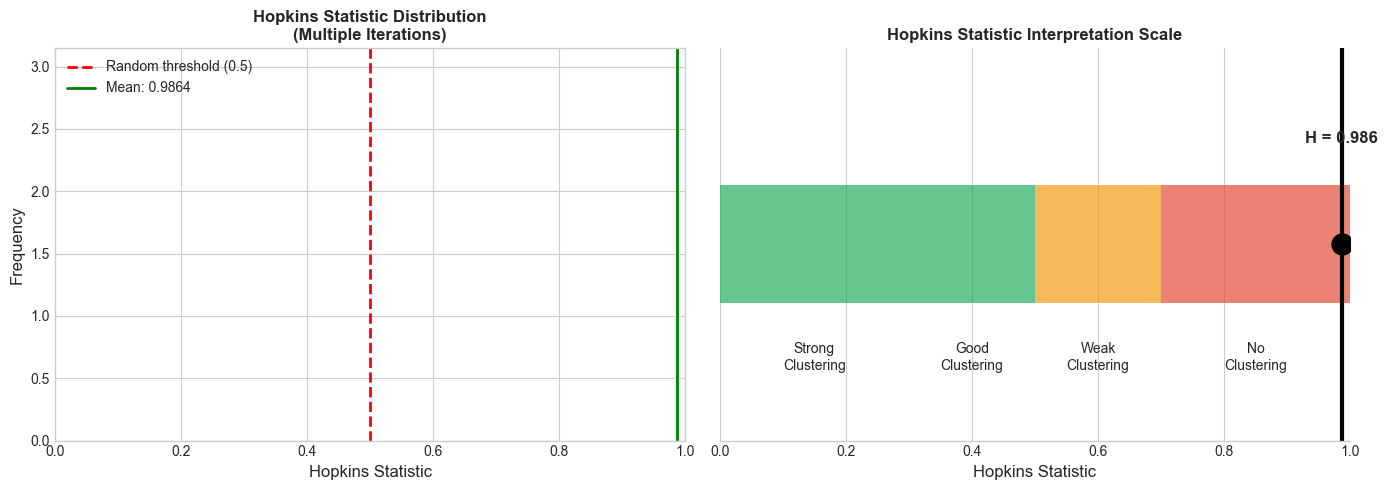

In [9]:
# Visualize Hopkins statistic results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Hopkins values distribution
ax1 = axes[0]
ax1.hist(hopkins_values, bins=10, color='steelblue', edgecolor='white', alpha=0.7)
ax1.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Random threshold (0.5)')
ax1.axvline(x=mean_hopkins, color='green', linestyle='-', linewidth=2, label=f'Mean: {mean_hopkins:.4f}')
ax1.set_xlabel('Hopkins Statistic', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Hopkins Statistic Distribution\n(Multiple Iterations)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.set_xlim(0, 1)

# Plot 2: Interpretation scale
ax2 = axes[1]
scale_colors = ['#27ae60', '#27ae60', '#f39c12', '#e74c3c']
scale_ranges = [0, 0.3, 0.5, 0.7, 1.0]
scale_labels = ['Strong\nClustering', 'Good\nClustering', 'Weak\nClustering', 'No\nClustering']

for i, (start, end, color) in enumerate(zip(scale_ranges[:-1], scale_ranges[1:], scale_colors)):
    ax2.barh(0, end - start, left=start, color=color, height=0.3, alpha=0.7)
    ax2.text((start + end) / 2, -0.25, scale_labels[i], ha='center', va='top', fontsize=10)

ax2.axvline(x=mean_hopkins, color='black', linestyle='-', linewidth=3)
ax2.plot(mean_hopkins, 0, 'ko', markersize=15)
ax2.text(mean_hopkins, 0.25, f'H = {mean_hopkins:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax2.set_xlim(0, 1)
ax2.set_ylim(-0.5, 0.5)
ax2.set_xlabel('Hopkins Statistic', fontsize=12)
ax2.set_title('Hopkins Statistic Interpretation Scale', fontsize=12, fontweight='bold')
ax2.set_yticks([])
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

## 6. Missing Data Investigation

### Missingness Pattern Analysis

Understanding missing data patterns is critical for:
- Selecting appropriate imputation strategies
- Assessing potential bias in clustering results
- Determining effective sample sizes

**Missing Data Mechanisms:**
- **MCAR** (Missing Completely at Random): Missingness is independent of all variables
- **MAR** (Missing at Random): Missingness depends on observed variables
- **MNAR** (Missing Not at Random): Missingness depends on the missing values themselves

In [10]:
# Missing Data Summary
print("=" * 80)
print("MISSING DATA SUMMARY")
print("=" * 80)

missing_counts = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Feature': df.columns,
    'Missing Count': missing_counts.values,
    'Missing %': missing_pct.values,
    'Complete Count': (len(df) - missing_counts).values
})

missing_df = missing_df.sort_values('Missing %', ascending=False)
missing_df = missing_df[missing_df['Missing Count'] > 0]

if len(missing_df) > 0:
    print("\nFeatures with Missing Values:")
    print("-" * 80)
    print(missing_df.to_string(index=False))
    
    total_missing_cells = df.isnull().sum().sum()
    total_cells = df.shape[0] * df.shape[1]
    overall_missing_pct = (total_missing_cells / total_cells) * 100
    
    print(f"\nOverall missing data: {total_missing_cells:,} cells ({overall_missing_pct:.2f}%)")
else:
    print("\nNo missing values detected in the dataset.")
    total_missing_cells = 0

# Complete cases analysis
complete_cases = df.dropna().shape[0]
print(f"\nComplete cases: {complete_cases:,} ({complete_cases/len(df)*100:.1f}%)")
print(f"Rows with at least one missing value: {len(df) - complete_cases:,} ({(len(df)-complete_cases)/len(df)*100:.1f}%)")

MISSING DATA SUMMARY

Features with Missing Values:
--------------------------------------------------------------------------------
          Feature  Missing Count  Missing %  Complete Count
        yearbuilt           3121  52.880380            2781
           region           1005  17.028126            4897
          country           1005  17.028126            4897
primaryspaceusage             55   0.931887            5847

Overall missing data: 5,186 cells (5.86%)

Complete cases: 2,726 (46.2%)
Rows with at least one missing value: 3,176 (53.8%)


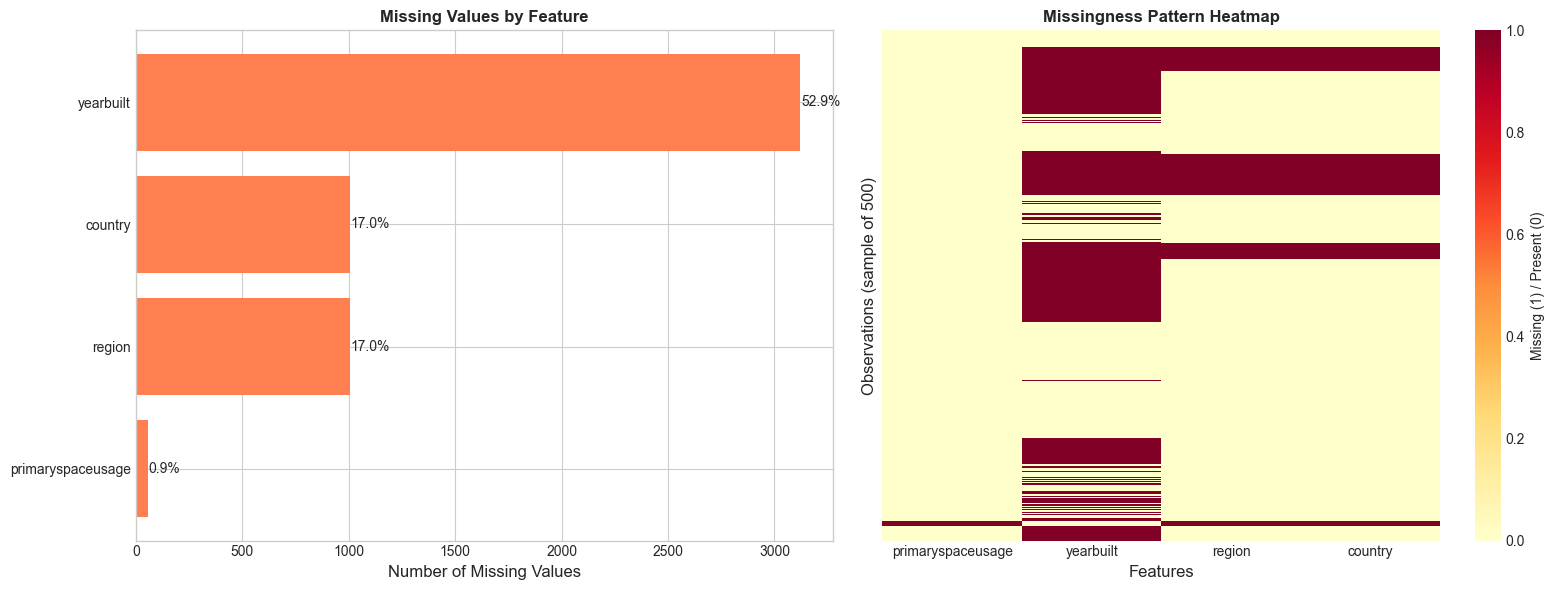

In [11]:
# Create missingness heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Missingness matrix (binary: 1 = missing, 0 = present)
missingness_matrix = df.isnull().astype(int)

# Plot 1: Missingness by feature (bar chart)
ax1 = axes[0]
missing_by_feature = df.isnull().sum()
missing_by_feature = missing_by_feature[missing_by_feature > 0].sort_values(ascending=True)

if len(missing_by_feature) > 0:
    bars = ax1.barh(range(len(missing_by_feature)), missing_by_feature.values, color='coral')
    ax1.set_yticks(range(len(missing_by_feature)))
    ax1.set_yticklabels(missing_by_feature.index)
    ax1.set_xlabel('Number of Missing Values', fontsize=12)
    ax1.set_title('Missing Values by Feature', fontsize=12, fontweight='bold')
    
    # Add percentage labels
    for i, (count, feature) in enumerate(zip(missing_by_feature.values, missing_by_feature.index)):
        pct = count / len(df) * 100
        ax1.text(count + 5, i, f'{pct:.1f}%', va='center', fontsize=10)
else:
    ax1.text(0.5, 0.5, 'No Missing Values', ha='center', va='center', fontsize=14, transform=ax1.transAxes)
    ax1.set_title('Missing Values by Feature', fontsize=12, fontweight='bold')

# Plot 2: Missingness heatmap (sample of rows for visibility)
ax2 = axes[1]
if total_missing_cells > 0:
    # Sample rows for visualization if dataset is large
    sample_size = min(500, len(df))
    sample_indices = np.random.choice(len(df), sample_size, replace=False)
    sample_indices = np.sort(sample_indices)
    
    missingness_sample = missingness_matrix.iloc[sample_indices]
    
    # Only show columns with missing values
    cols_with_missing = missingness_matrix.columns[missingness_matrix.sum() > 0].tolist()
    if cols_with_missing:
        sns.heatmap(missingness_sample[cols_with_missing], cmap='YlOrRd', cbar_kws={'label': 'Missing (1) / Present (0)'}, 
                    ax=ax2, yticklabels=False)
        ax2.set_xlabel('Features', fontsize=12)
        ax2.set_ylabel(f'Observations (sample of {sample_size})', fontsize=12)
        ax2.set_title('Missingness Pattern Heatmap', fontsize=12, fontweight='bold')
    else:
        ax2.text(0.5, 0.5, 'No Missing Values', ha='center', va='center', fontsize=14, transform=ax2.transAxes)
        ax2.set_title('Missingness Pattern Heatmap', fontsize=12, fontweight='bold')
else:
    ax2.text(0.5, 0.5, 'No Missing Values\nDataset is complete', ha='center', va='center', fontsize=14, transform=ax2.transAxes)
    ax2.set_title('Missingness Pattern Heatmap', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### 6.1 Missing Data Impact Analysis

Comparison of effective sample sizes under different missing data handling strategies:

In [12]:
# Missing Data Impact Analysis
print("=" * 80)
print("MISSING DATA HANDLING STRATEGIES - IMPACT ANALYSIS")
print("=" * 80)

# Define clustering features
cluster_features = ['yearbuilt', 'Avg_AirTemp_Annual', 'sqm', 'primaryspaceusage', 'region', 'meter']
available_cluster_features = [f for f in cluster_features if f in df.columns]

# Strategy 1: Listwise deletion (complete cases only)
complete_cases_all = df.dropna().shape[0]
complete_cases_clustering = df[available_cluster_features].dropna().shape[0]

# Strategy 2: Feature-wise analysis
print("\nStrategy 1: LISTWISE DELETION")
print("-" * 60)
print(f"  All features - Complete cases: {complete_cases_all:,} ({complete_cases_all/len(df)*100:.1f}%)")
print(f"  Clustering features only - Complete cases: {complete_cases_clustering:,} ({complete_cases_clustering/len(df)*100:.1f}%)")
print(f"  Data loss: {len(df) - complete_cases_clustering:,} observations")

# Strategy 2: Pairwise analysis (theoretical)
print("\nStrategy 2: PAIRWISE DELETION (for correlation analysis)")
print("-" * 60)
print("  Effective sample sizes vary by feature pair.")
print("  Minimum pairwise complete cases:")

if len(available_cluster_features) > 1:
    min_pairwise = len(df)
    min_pair = ('', '')
    for i, f1 in enumerate(available_cluster_features):
        for f2 in available_cluster_features[i+1:]:
            pairwise_complete = df[[f1, f2]].dropna().shape[0]
            if pairwise_complete < min_pairwise:
                min_pairwise = pairwise_complete
                min_pair = (f1, f2)
    print(f"    {min_pair[0]} × {min_pair[1]}: {min_pairwise:,} observations")

# Strategy 3: Imputation scenarios
print("\nStrategy 3: IMPUTATION")
print("-" * 60)
print("  With appropriate imputation, full sample size can be retained.")
print(f"  Potential sample size: {len(df):,} observations")

# Imputation methods suitable for each feature type
print("\n  Recommended imputation approaches:")
for col in available_cluster_features:
    if col in df.select_dtypes(include=[np.number]).columns:
        missing_count = df[col].isnull().sum()
        if missing_count > 0:
            print(f"    {col} (numerical): Median/Mean imputation or group-based median")
    else:
        missing_count = df[col].isnull().sum()
        if missing_count > 0:
            print(f"    {col} (categorical): Mode imputation or create 'Unknown' category")

# Summary comparison
print("\n" + "=" * 80)
print("SAMPLE SIZE COMPARISON BY STRATEGY")
print("=" * 80)
strategies = {
    'Listwise Deletion': complete_cases_clustering,
    'Imputation (Full Sample)': len(df)
}

print(f"{'Strategy':<30} {'Sample Size':>15} {'% of Original':>15}")
print("-" * 60)
for strategy, size in strategies.items():
    pct = size / len(df) * 100
    print(f"{strategy:<30} {size:>15,} {pct:>14.1f}%")

MISSING DATA HANDLING STRATEGIES - IMPACT ANALYSIS

Strategy 1: LISTWISE DELETION
------------------------------------------------------------
  All features - Complete cases: 2,726 (46.2%)
  Clustering features only - Complete cases: 2,726 (46.2%)
  Data loss: 3,176 observations

Strategy 2: PAIRWISE DELETION (for correlation analysis)
------------------------------------------------------------
  Effective sample sizes vary by feature pair.
  Minimum pairwise complete cases:
    yearbuilt × primaryspaceusage: 2,726 observations

Strategy 3: IMPUTATION
------------------------------------------------------------
  With appropriate imputation, full sample size can be retained.
  Potential sample size: 5,902 observations

  Recommended imputation approaches:
    yearbuilt (numerical): Median/Mean imputation or group-based median
    primaryspaceusage (categorical): Mode imputation or create 'Unknown' category
    region (categorical): Mode imputation or create 'Unknown' category

SAMPLE

## 7. Export Assessment Report to Markdown

The following cell compiles all findings into a comprehensive markdown report.

In [13]:
# Generate comprehensive markdown report
report_content = """# Data Adequacy Assessment Report

## Executive Summary

This report presents a comprehensive data adequacy assessment for the building energy calibration clustering dataset. The assessment evaluates four critical dimensions: variability characteristics, sample size adequacy, cluster tendency, and missing data patterns.

---

## 1. Dataset Overview

"""

# Add dataset info
report_content += f"""| Attribute | Value |
|-----------|-------|
| Total observations | {len(df):,} |
| Total features | {df.shape[1]} |
| Numerical features | {len(numerical_features)} |
| Categorical features | {len(categorical_features)} |
| Complete cases | {df.dropna().shape[0]:,} ({df.dropna().shape[0]/len(df)*100:.1f}%) |

### Features in Dataset

**Numerical Features:** {', '.join(numerical_features)}

**Categorical Features:** {', '.join(categorical_features)}

---

## 2. Variability Assessment

### 2.1 Coefficient of Variation Analysis

The coefficient of variation (CV) measures relative variability as the ratio of standard deviation to mean, expressed as a percentage. Features with CV below 10% may lack sufficient discriminatory power for clustering, while features with CV above 100% may require transformation.

| Feature | Mean | Std Dev | CV (%) | Classification |
|---------|------|---------|--------|----------------|
"""

# Add CV table
for _, row in cv_df.iterrows():
    report_content += f"| {row['Feature']} | {row['Mean']:.4f} | {row['Std Dev']:.4f} | {row['CV (%)']:.2f} | {row['Variability Classification']} |\n"

# Add CV interpretation
report_content += f"""
### 2.2 Variability Findings

"""

if low_var:
    report_content += f"""**Features with Insufficient Variation (CV < 10%):** {', '.join(low_var)}

These features demonstrate limited variability relative to their means, which may reduce their effectiveness in differentiating clusters. Consideration should be given to either excluding these features or investigating whether the low variation is meaningful in the context of building energy analysis.

"""
else:
    report_content += """**Features with Insufficient Variation:** None identified. All features demonstrate adequate variability for clustering analysis.

"""

if high_var:
    report_content += f"""**Features with Excessive Variation (CV > 100%):** {', '.join(high_var)}

These features exhibit high variability, potentially due to outliers or inherently skewed distributions. Log transformation or other variance-stabilizing transformations are recommended before clustering.

"""
else:
    report_content += """**Features with Excessive Variation:** None identified.

"""

# Add distribution analysis
report_content += """### 2.3 Distribution Characteristics

| Feature | Skewness | Kurtosis | Transformation Recommended |
|---------|----------|----------|---------------------------|
"""

for col, analysis in distribution_analysis.items():
    transform_rec = "Yes" if analysis['needs_transformation'] else "No"
    report_content += f"| {col} | {analysis['skewness']:.2f} | {analysis['kurtosis']:.2f} | {transform_rec} |\n"

features_needing_transform = [col for col, analysis in distribution_analysis.items() if analysis['needs_transformation']]
if features_needing_transform:
    report_content += f"""
Features exhibiting substantial skewness (|skew| > 1) or excess kurtosis (kurtosis > 3) include: {', '.join(features_needing_transform)}. These features may benefit from log or power transformations to achieve more symmetric distributions suitable for distance-based clustering algorithms.

"""

report_content += """---

## 3. Sample Size Analysis

### 3.1 Sample Size Requirements

Sample size adequacy for clustering is evaluated against established guidelines:
- **Minimum requirement:** 50 observations per expected cluster
- **Recommended:** 100 observations per expected cluster
- **Feature-based minimum:** 10 observations per feature

"""

report_content += f"""| Expected Clusters (k) | Minimum Required | Recommended | Feature-Based Min | Assessment |
|-----------------------|------------------|-------------|-------------------|------------|
"""

for result in sample_size_results:
    report_content += f"| {result['k']} | {result['min_required']:,} | {result['rec_required']:,} | {result['feature_based']} | {result['adequacy']} |\n"

report_content += f"""
### 3.2 Observations per Cluster

With {len(df):,} total observations:

| Expected Clusters (k) | Average Observations per Cluster | Assessment |
|-----------------------|----------------------------------|------------|
"""

for k in expected_clusters_range:
    avg = len(df) / k
    if avg >= 100:
        assess = "Excellent"
    elif avg >= 50:
        assess = "Adequate"
    else:
        assess = "Potentially insufficient"
    report_content += f"| {k} | {avg:,.0f} | {assess} |\n"

report_content += f"""
### 3.3 Sample Size Findings

The dataset contains {len(df):,} observations. Based on the sample size analysis:

"""

# Determine overall sample size adequacy
max_adequate_k = max([r['k'] for r in sample_size_results if '✓' in r['adequacy'] or '○' in r['adequacy']], default=0)
if max_adequate_k >= 10:
    report_content += f"""- The sample size is **excellent** for clustering with up to {max_adequate_k} clusters.
- Even with conservative estimates, there are sufficient observations to support stable cluster formation.
"""
elif max_adequate_k >= 5:
    report_content += f"""- The sample size is **adequate** for clustering with up to {max_adequate_k} clusters.
- For analyses requiring more clusters, additional data collection may improve stability.
"""
else:
    report_content += """- The sample size may be **marginal** for complex clustering analyses.
- Careful validation of cluster stability is recommended.
"""

report_content += f"""
---

## 4. Hopkins Statistic Analysis

### 4.1 Cluster Tendency Assessment

The Hopkins statistic measures whether a dataset exhibits inherent clustering structure or appears uniformly distributed. Values significantly below 0.5 indicate good clustering potential.

| Metric | Value |
|--------|-------|
| Hopkins Statistic (Mean) | {mean_hopkins:.4f} |
| Standard Deviation | {std_hopkins:.4f} |
| Number of Iterations | {n_iterations} |

### 4.2 Interpretation

"""

if mean_hopkins < 0.3:
    report_content += f"""The Hopkins statistic of **{mean_hopkins:.4f}** indicates **strong clustering tendency**. The dataset exhibits clear non-random structure, suggesting that meaningful clusters exist within the data. Clustering algorithms are expected to produce stable and interpretable results.

"""
elif mean_hopkins < 0.5:
    report_content += f"""The Hopkins statistic of **{mean_hopkins:.4f}** indicates **moderate to good clustering tendency**. The dataset demonstrates meaningful structure that deviates from random uniformity. Clustering analysis is appropriate, though results should be validated through multiple methods.

"""
elif mean_hopkins < 0.7:
    report_content += f"""The Hopkins statistic of **{mean_hopkins:.4f}** indicates **weak clustering tendency**. The dataset shows limited natural clustering structure. Clustering results should be interpreted with caution, and alternative analytical approaches may be considered.

"""
else:
    report_content += f"""The Hopkins statistic of **{mean_hopkins:.4f}** indicates **no significant clustering tendency**. The data appears uniformly distributed without inherent cluster structure. Clustering analysis may not yield meaningful results.

"""

report_content += """---

## 5. Missing Data Analysis

### 5.1 Missing Data Summary

"""

if len(missing_df) > 0:
    report_content += """| Feature | Missing Count | Missing % | Complete Count |
|---------|---------------|-----------|----------------|
"""
    for _, row in missing_df.iterrows():
        report_content += f"| {row['Feature']} | {int(row['Missing Count']):,} | {row['Missing %']:.2f}% | {int(row['Complete Count']):,} |\n"
    
    report_content += f"""
### 5.2 Missingness Pattern Assessment

The missing data pattern appears to be primarily concentrated in specific features. The pattern suggests:

"""
    # Assess missingness pattern
    max_missing_pct = missing_df['Missing %'].max()
    if max_missing_pct < 5:
        report_content += """- **Low overall missingness** (< 5% for all features)
- Missing data likely represents **MCAR (Missing Completely at Random)** or minor data collection gaps
- Listwise deletion is a viable option with minimal impact on sample size

"""
    elif max_missing_pct < 20:
        report_content += """- **Moderate missingness** in some features
- Pattern should be investigated to determine if **MAR (Missing at Random)** applies
- Imputation is recommended to preserve sample size

"""
    else:
        report_content += """- **Substantial missingness** in one or more features
- Features with very high missingness may need exclusion or specialized treatment
- Investigation of missingness mechanism is strongly recommended

"""
else:
    report_content += """No missing values were detected in the dataset. All features contain complete observations, eliminating concerns about missing data handling strategies.

"""

report_content += f"""### 5.3 Impact on Effective Sample Size

| Handling Strategy | Effective Sample Size | % of Original |
|-------------------|----------------------|---------------|
| Listwise Deletion | {complete_cases_clustering:,} | {complete_cases_clustering/len(df)*100:.1f}% |
| Full Imputation | {len(df):,} | 100.0% |

"""

report_content += """---

## 6. Summary and Recommendations

### 6.1 Overall Data Adequacy Assessment

"""

# Generate overall assessment
assessment_items = []

# Variability assessment
if not low_var and not high_var:
    assessment_items.append("✓ **Variability:** All features demonstrate adequate variability for clustering")
elif high_var and not low_var:
    assessment_items.append("○ **Variability:** Some features require transformation due to high variability")
elif low_var:
    assessment_items.append("△ **Variability:** Some features show insufficient variation")

# Sample size assessment
if max_adequate_k >= 10:
    assessment_items.append("✓ **Sample Size:** Excellent for clustering analyses")
elif max_adequate_k >= 5:
    assessment_items.append("○ **Sample Size:** Adequate for moderate clustering complexity")
else:
    assessment_items.append("△ **Sample Size:** May be marginal for complex analyses")

# Hopkins statistic assessment
if mean_hopkins < 0.5:
    assessment_items.append(f"✓ **Cluster Tendency:** Good clustering potential (H = {mean_hopkins:.3f})")
else:
    assessment_items.append(f"△ **Cluster Tendency:** Limited clustering structure (H = {mean_hopkins:.3f})")

# Missing data assessment
if complete_cases_clustering / len(df) > 0.95:
    assessment_items.append("✓ **Missing Data:** Minimal impact on analysis")
elif complete_cases_clustering / len(df) > 0.80:
    assessment_items.append("○ **Missing Data:** Moderate impact; imputation recommended")
else:
    assessment_items.append("△ **Missing Data:** Substantial impact; careful handling required")

for item in assessment_items:
    report_content += f"- {item}\n"

report_content += """
### 6.2 Recommendations

1. **Feature Transformation:** Apply log transformation to features with high CV or significant skewness before clustering.

2. **Feature Selection:** Consider the contribution of each feature to cluster differentiation; features with very low CV may be candidates for exclusion.

3. **Cluster Validation:** Use multiple validation metrics (silhouette score, Calinski-Harabasz index) to confirm optimal cluster numbers.

4. **Missing Data Strategy:** Implement appropriate imputation for missing values to maximize effective sample size while maintaining data integrity.

5. **Sensitivity Analysis:** Conduct sensitivity analyses with different numbers of clusters and feature subsets to ensure robust findings.

---

*Report generated on: """ + pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S') + """*
"""

# Write report to file
report_path = "../data_adequacy_assessment.md"
with open(report_path, 'w') as f:
    f.write(report_content)

print("=" * 80)
print("REPORT EXPORTED SUCCESSFULLY")
print("=" * 80)
print(f"\nReport saved to: {report_path}")
print(f"Report length: {len(report_content):,} characters")

REPORT EXPORTED SUCCESSFULLY

Report saved to: ../data_adequacy_assessment.md
Report length: 7,481 characters
